In [1]:
%env CUDA_VISIBLE_DEVICES=2
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env JAX_ENABLE_X64=True

from datasets import PointDataset
from models import MLPCNF

env: CUDA_VISIBLE_DEVICES=2
env: XLA_PYTHON_CLIENT_PREALLOCATE=false
env: JAX_ENABLE_X64=True


In [2]:
import jax.random as jr
dataset = PointDataset(dim=3)
x_shapes, y_shape = dataset.xy_shapes()
model = MLPCNF(x_dim=len(x_shapes), y_dim=y_shape[-1], hidden=32, depth=4, rng=jr.key(0))
model, losses = model.fit(dataset, batch_size=4*1024, epochs=10, learning_rate=1e-3)

100%|██████████| 10/10 [00:19<00:00,  2.00s/it, loss=0.103348724898637] 


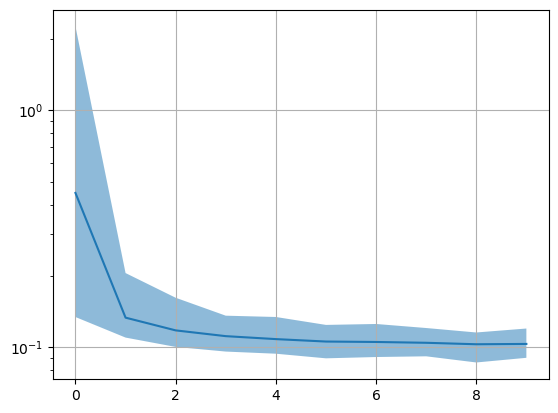

In [3]:
import matplotlib.pyplot as plt
plt.semilogy(losses.mean(axis=-1))
plt.fill_between(range(len(losses)), losses.min(axis=-1), losses.max(axis=-1), alpha=0.5)
plt.grid()
plt.show()

In [4]:
from tqdm.auto import tqdm
import corner
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as jr
import blackjax

NSAMPLES = 4*1024


@jax.jit
def cnf_sample(rng, y):
    @jax.vmap
    def batch_push(x0):
        return model.push(dataset.priors, x0, y)

    x0 = jax.vmap(dataset.sample_params)(jr.split(rng, NSAMPLES))
    x1, xt = batch_push(x0)
    return jnp.concat(x1, axis=-1)


@jax.jit
def nuts_sample(rng, y, x_true):
    walkers, chain_len = 64, NSAMPLES // 64
    nuts = blackjax.nuts(lambda x: dataset.log_posterior(x, y), 1e-3, jnp.ones(3))

    def scan_fn(state, rng):
        state, info = nuts.step(rng, state)
        return state, state.position

    def get_chain(rng):
        rng, rng_init = jr.split(rng)
        state = nuts.init(x_true, rng_init)
        state, burnt = jax.lax.scan(scan_fn, state, jr.split(rng, chain_len // 10))
        _, chain = jax.lax.scan(scan_fn, state, jr.split(rng, chain_len))
        return chain

    chains = jax.vmap(get_chain)(jr.split(rng, walkers))
    return jnp.concat(chains, axis=-1).reshape(NSAMPLES, -1)

  0%|          | 0/10 [00:00<?, ?it/s]

sampling using CNF...
sampling using NUTS...


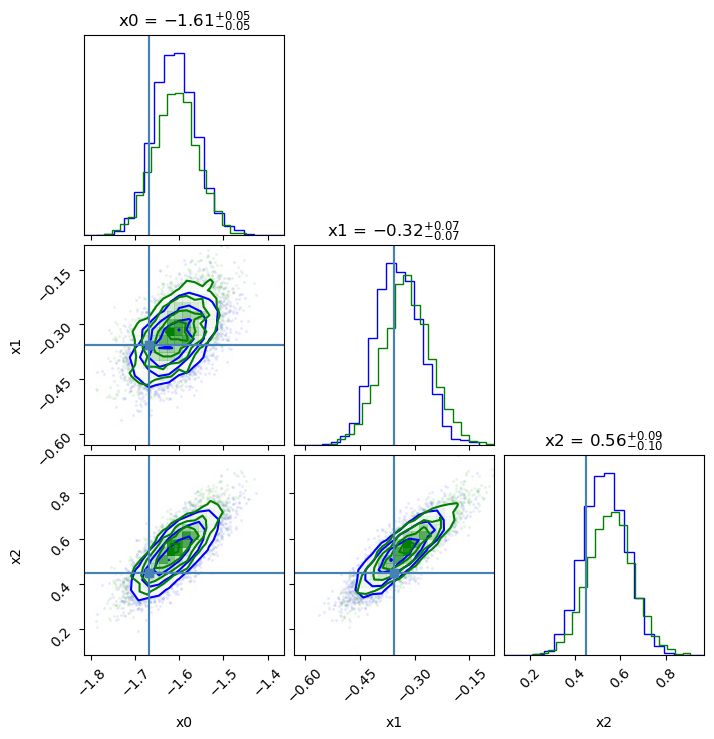

sampling using CNF...
sampling using NUTS...


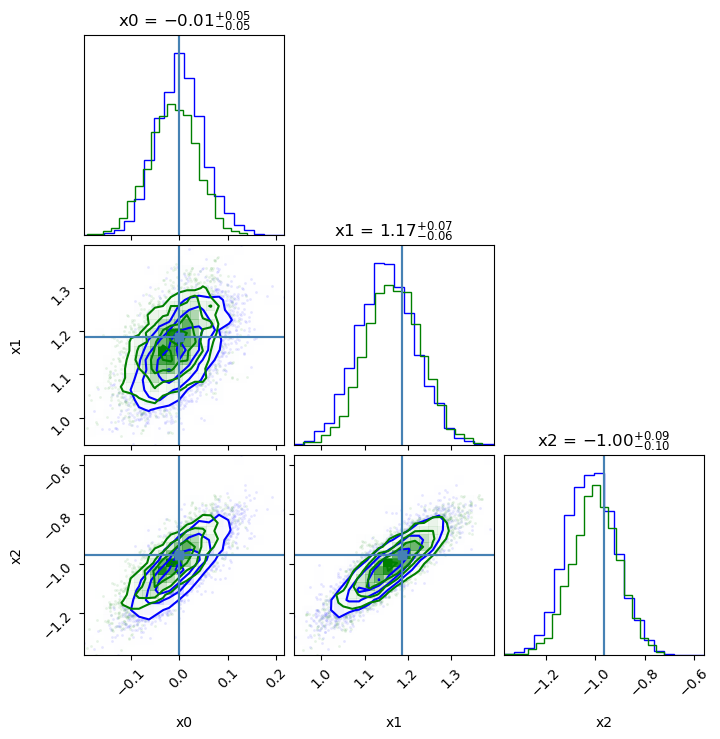

sampling using CNF...
sampling using NUTS...


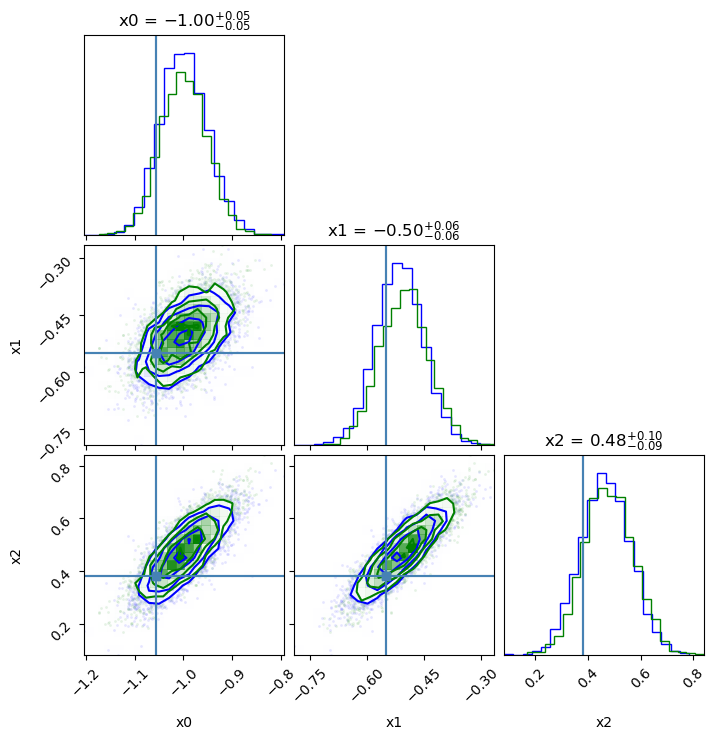

sampling using CNF...
sampling using NUTS...


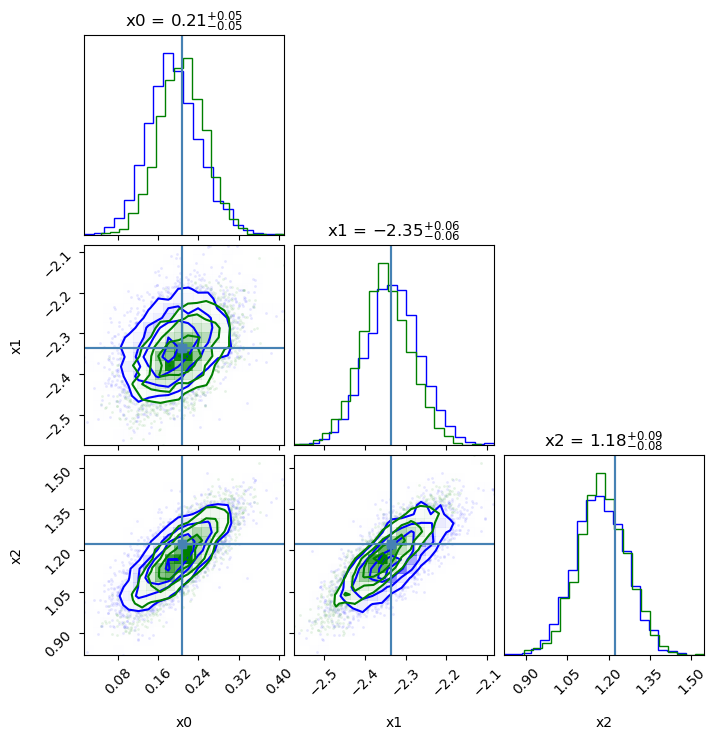

sampling using CNF...
sampling using NUTS...


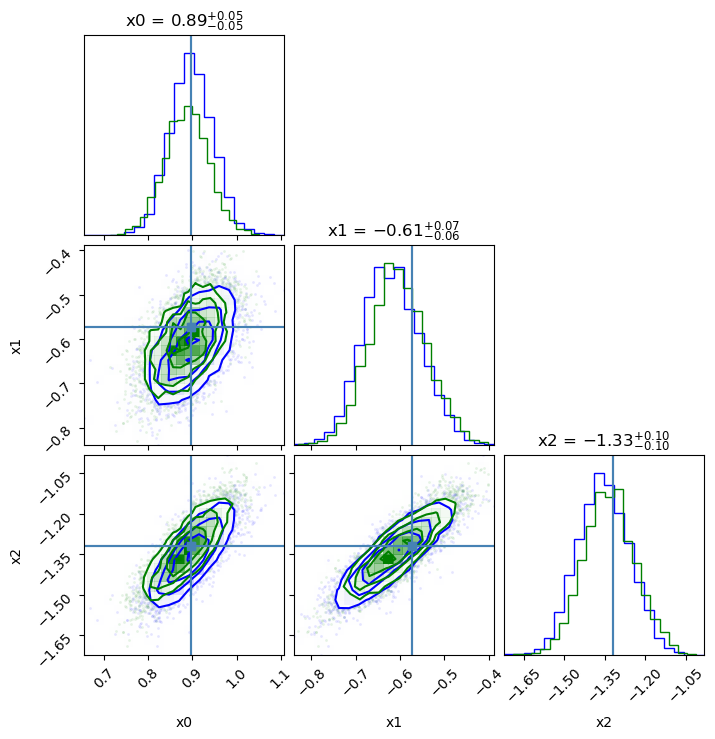

sampling using CNF...
sampling using NUTS...


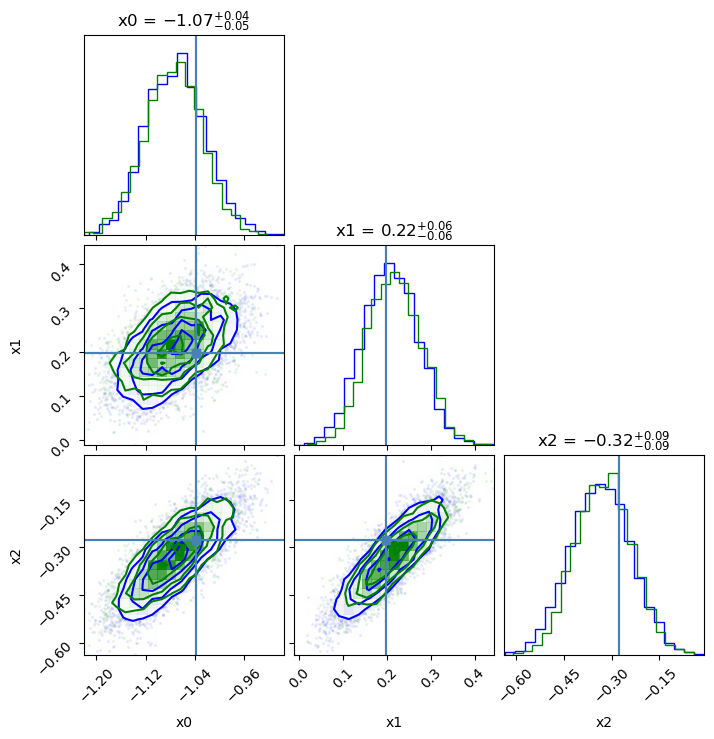

sampling using CNF...
sampling using NUTS...


In [ ]:
def corner_plot(rng):
    rng_x, rng_y, rng_cnf, rng_mcmc = jr.split(rng, 4)
    x_true = dataset.sample_params(rng_x)
    y = dataset.sample_observation(rng_y, x_true)

    print("sampling using CNF...")
    x_cnf = np.array(cnf_sample(rng_cnf, y))
    print("sampling using NUTS...")
    x_mcmc = np.array(nuts_sample(rng_mcmc, y, x_true))

    # plot corner
    corner_kwargs: dict = dict(
        labels=dataset.param_names,
        show_titles=True,
        truths=np.array(jnp.concat(x_true, axis=-1)),
    )
    fig = None
    fig = corner.corner(x_cnf, color="blue", fig=fig, **corner_kwargs)
    fig = corner.corner(x_mcmc, color="green", fig=fig, **corner_kwargs)
    plt.show()


for rng in tqdm(jr.split(jr.key(0), 10)):
    corner_plot(rng)